In [1]:
import torch
import torch.nn as nn
from torch.nn import Sequential as Seq,Linear,ReLU,BatchNorm1d
from torch_scatter import scatter_mean

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from InteractionNetwork import InteractionNetwork

<hr>
load pretrained model

In [2]:
model=InteractionNetwork()
model.load_state_dict(torch.load("../data/model/IN_best_dec10.pth"))

<All keys matched successfully>

end of load pretrained model
<hr>
get data

In [3]:
# get data

import yaml
from GraphDataset import GraphDataset


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



with open('definitions.yml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions = yaml.load(file, Loader=yaml.FullLoader)
    
features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']
ntracks = definitions['ntracks']


file_names=["/teams/DSC180A_FA20_A00/b06particlephysics/train/ntuple_merged_10.root"]
graph_dataset = GraphDataset('data', features, labels, spectators, n_events=10000, n_events_merge=1000, 
                             file_names=file_names)

In [4]:
b=graph_dataset[0]
g=b[0]
g.batch=torch.tensor(np.zeros(g.x.shape[0]).astype("int64"))
g

Data(batch=[38], edge_index=[2, 1406], u=[1, 2], x=[38, 48], y=[1, 2])

end of get data<hr>

functions copied from `src.util`

In [52]:
def copy(layer):
    """
    create a deep copy of provided layer
    """
    layer_cp=eval("nn."+layer.__repr__())
    layer_cp.load_state_dict(layer.state_dict())
    
    return layer_cp


def rho(layer):
    """
    create a deep copy of a linear layer
    """
    W=layer.weight.detach()
    b=layer.bias.detach()
    
    return lambda a: a@W.T+b


def lrp(layer,a,R,epsilon=1e-9,relu=False):
    """
    LRP-epsilon, with epsilon set to 1e-9 by default
    """
    a=torch.tensor(a,requires_grad=True)
    a.retain_grad()
    
    z=epsilon+rho(layer)(a)
    s=R/(z+1e-9)
    (z@s.data).sum().backward()
    c=a.grad
    
    if relu:
        R=nn.ReLU()(z.sum())*c
    else:
        R=a*c
    
    return R


In [53]:
for i in (model.interactionnetwork.children()):
    for n,j in i.named_modules():
        if n and n[-1].isnumeric() and ("." in n):
            print(n,j.__repr__())

edge_mlp.0 Linear(in_features=96, out_features=128, bias=True)
edge_mlp.1 BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
edge_mlp.2 ReLU()
edge_mlp.3 Linear(in_features=128, out_features=128, bias=True)
node_mlp_1.0 Linear(in_features=176, out_features=128, bias=True)
node_mlp_1.1 BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
node_mlp_1.2 ReLU()
node_mlp_1.3 Linear(in_features=128, out_features=128, bias=True)
node_mlp_2.0 Linear(in_features=176, out_features=128, bias=True)
node_mlp_2.1 BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
node_mlp_2.2 ReLU()
node_mlp_2.3 Linear(in_features=128, out_features=128, bias=True)
global_mlp.0 Linear(in_features=128, out_features=128, bias=True)
global_mlp.1 BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
global_mlp.2 ReLU()
global_mlp.3 Linear(in_features=128, out_features=2, bias=True)


layer name `n` ends with 0-2 -> joint together, rectified linear layer
layer name `n` ends with 3 -> standalone linear layer

`R2` (`node_mlp_1.0-2`) and `R4` (`node_mlp_2.0-2`) contains partial relevance score of input `x`

In [156]:
layers={}
cnt=0
for i in (model.interactionnetwork.children()):
    layer=[]
    for n,j in i.named_modules():
        if n and n[-1].isnumeric() and ("." in n):
            if n[-1] in ["0","1","2"]:
                layer.append(copy(j))
            else:
                layers[f"L{cnt}"]=Seq(*layer)
                layer=[]
                cnt+=1
                
                layers[f"L{cnt}"]=copy(j)
                cnt+=1
layers

{'L0': Sequential(
   (0): Linear(in_features=96, out_features=128, bias=True)
   (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 'L1': Linear(in_features=128, out_features=128, bias=True),
 'L2': Sequential(
   (0): Linear(in_features=176, out_features=128, bias=True)
   (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 'L3': Linear(in_features=128, out_features=128, bias=True),
 'L4': Sequential(
   (0): Linear(in_features=176, out_features=128, bias=True)
   (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 'L5': Linear(in_features=128, out_features=128, bias=True),
 'L6': Sequential(
   (0): Linear(in_features=128, out_features=128, bias=True)
   (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 'L7': Linear(in_features=128, out_features=2, bias=True)}

In [157]:
row,col=g.edge_index
n_tracks=g.x.shape[0]
x=torch.tensor(torch.cat([g.x[row],g.x[col]],1).clone().detach().numpy(),
               requires_grad=True)

In [158]:
activations={}
activations["a0"]=layers["L0"].forward(x)

In [159]:
M_col=torch.zeros(col.shape[0],n_tracks,dtype=torch.float32)
for i,j in enumerate(col):
    M_col[i,j]=1
M_col=M_col.T

In [166]:
for i in range(1,len(layers.keys())):
    if i==2:
        a=torch.tensor(torch.cat([g.x[row],activations[f"a{i-1}"]],1).clone().detach().numpy(),
                       requires_grad=True,dtype=torch.float32)
    elif i==4:
        a=torch.tensor(torch.cat([g.x,M_col@activations[f"a{i-1}"]],1).clone().detach().numpy(),
                       requires_grad=True,dtype=torch.float32)
    elif i==6:
        layers[f"L{i}"].eval()
        a=torch.tensor((torch.ones(1,n_tracks)@activations[f"a{i-1}"]/n_tracks).clone().detach().numpy(),
                       requires_grad=True,dtype=torch.float32)
    else:
        a=torch.tensor(activations[f"a{i-1}"].clone().detach().numpy(),
                      requires_grad=True,dtype=torch.float32)
    
    activations[f"a{i}"]=layers[f"L{i}"].forward(a)

In [167]:
for k in activations.keys():
    print(k,activations[k].shape)

a0 torch.Size([1406, 128])
a1 torch.Size([1406, 128])
a2 torch.Size([1406, 128])
a3 torch.Size([1406, 128])
a4 torch.Size([38, 128])
a5 torch.Size([38, 128])
a6 torch.Size([1, 128])
a7 torch.Size([1, 2])


In [168]:
prob=nn.Softmax(1)(activations["a7"])
eta_c=torch.log(prob[0,1]/(1-prob[0,1]))
prob,eta_c

(tensor([[0.9731, 0.0269]], grad_fn=<SoftmaxBackward>),
 tensor(-3.5897, grad_fn=<LogBackward>))

In [169]:
def LRP(i):
    a=torch.tensor(activations[f"a{i-1}"].clone().detach().numpy(),
                      requires_grad=True,dtype=torch.float32)
    a.retain_grad()
    
    z=layers[f"L{i}"].forward(a)
    s=R[f"R{i+1}"]/(z+1e-9)
    
    (z*s.data).sum().backward()
    c=a.grad
    R[f"R{i}"]=a*c

In [170]:
R={}
R[f"R{8}"]=prob

for i in range(len(layers.keys())-1,1,-1):
    LRP(i)
    
#     if i==2:

#     elif i==4:

#     elif i==6:
#         R[f"R{i}"]/=n_tracks

#     else:
#         continue

RuntimeError: size mismatch, m1: [1406 x 128], m2: [176 x 128] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:41

In [171]:
for k in R.keys():
    print(k,R[k].shape,R[k].sum())

R8 torch.Size([1, 2]) tensor(1., grad_fn=<SumBackward0>)
R7 torch.Size([1, 128]) tensor(1.0010, grad_fn=<SumBackward0>)
R6 torch.Size([38, 128]) tensor(160.3599, grad_fn=<SumBackward0>)
R5 torch.Size([38, 128]) tensor(41.5787, grad_fn=<SumBackward0>)


In [153]:
160.3599/n_tracks

4.219997368421053

In [125]:

(z=activations["a7"]
s=activations["a7"]/z
(z*s.data).sum().backward()
c=a.grad
r=a*c
r.shape

torch.Size([1, 128])

In [121]:
activations["a6"].shape

torch.Size([1, 128])

<hr>

In [134]:
def hook(dest,key,idx=0,row=None,n_track=None):        
    def forward_hook(model,input,output):
        a=input[0].detach()
        a.requires_grad=True
        a.retain_grad()
        inputs[key]=a
        m[key]=model
        
        def f(R,rho=lambda x:x,model=model,epsilon=1e-9):   
            if idx>0:
                temp=R[:,:idx]
                R=R[:,idx:]
                
            if not (row is None):
                R=R[row]/n_track
            
            z=epsilon+rho(model).forward(a)
            s=R/(z+1e-9)
            (z*s.data).sum().backward()
            c=a.grad
            R=(a*c)
            
            
            if idx>0:
                return R,temp
            return R
        
        dest.append((key,f))
    
        
    return forward_hook

In [135]:
A=[]
inputs={}
hooks={}
R={}
m={}

row,col=g.edge_index

model=InteractionNetwork()
model.load_state_dict(torch.load("../data/model/IN_best_dec10.pth"))

for i in (model.interactionnetwork.children()):
    for n,j in i.named_modules():
        if n and n[-1].isnumeric() and ("." in n):
            # special cases: split before node 1.3 and edge 3
            m[n]=j
            if n=="node_mlp_1.3":
                h=j.register_forward_hook(hook(A,n,idx=48,row=row,n_track=g.x.shape[0]))
            elif n=="edge_mlp.3":
                h=j.register_forward_hook(hook(A,n,idx=48))
            else:
                h=j.register_forward_hook(hook(A,n))
                
            hooks[n]=h
            

In [136]:
model.eval()
out,edge_attr=model(g.x,g.edge_index,g.batch)

In [137]:
special_layers=["edge_mlp.1","edge_mlp.2",
          "node_mlp_1.1","node_mlp_1.2",
          "node_mlp_2.1","node_mlp_2.2",
          "global_mlp.1","global_mlp.2"]

multipath_layer=["node_mlp_1.3","edge_mlp.3"]

n,f=A.pop()
R[n]=f(out)
n_prev=n
layers=[]
while len(A):
    n,f=A.pop()
    hooks[n].remove()
    print(n)
    
    if n in special_layers:
        print(f"    special layer {n}")
        layers.append(m[n])
        
    elif len(layers):
        print(f"    joint layer {n}")
        layers.append(m[n])
        
        if isinstance(R[n_prev],tuple):
            temp=f(R[n_prev][0],model=Seq(*layers[::-1]))
        
        else:
            temp=f(R[n_prev],model=Seq(*layers[::-1]))
        
        
        
        if isinstance(temp,tuple):
            R[n],R[f"input_{n}"]=temp
        else:
            R[n]=temp
#         if n in multipath_layer:
#             R[n],R[f"input_{n}"]=f(R[n_prev],model=Seq(*layers[::-1]))
#         else:
#             R[n]=f(R[n_prev],model=Seq(*layers[::-1]))
        layers=[]
        n_prev=n
    else:
        print(f"    normal layer {n}")
        R[n]=f(R[n_prev])
        n_prev=n

global_mlp.2
    special layer global_mlp.2
global_mlp.1
    special layer global_mlp.1
global_mlp.0
    joint layer global_mlp.0
node_mlp_2.3
    normal layer node_mlp_2.3
node_mlp_2.2
    special layer node_mlp_2.2
node_mlp_2.1
    special layer node_mlp_2.1
node_mlp_2.0
    joint layer node_mlp_2.0
node_mlp_1.3
    normal layer node_mlp_1.3
node_mlp_1.2
    special layer node_mlp_1.2
node_mlp_1.1
    special layer node_mlp_1.1
node_mlp_1.0
    joint layer node_mlp_1.0
edge_mlp.3
    normal layer edge_mlp.3
edge_mlp.2
    special layer edge_mlp.2
edge_mlp.1
    special layer edge_mlp.1
edge_mlp.0
    joint layer edge_mlp.0


In [138]:
R.keys()

dict_keys(['global_mlp.3', 'global_mlp.0', 'node_mlp_2.3', 'node_mlp_2.0', 'node_mlp_1.3', 'node_mlp_1.0', 'edge_mlp.3', 'edge_mlp.0'])

In [139]:
R["edge_mlp.0"].shape

torch.Size([1406, 96])

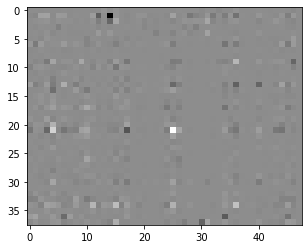

In [145]:
row,col=g.edge_index
M=torch.zeros(col.shape[0],g.x.shape[0])
for i,j in enumerate(col):
    M[i,j]=1
M=M.T

val=(M@R["edge_mlp.0"])[:,48:].detach().cpu().numpy()
row,col=val.shape

fig,ax=plt.subplots()
im=ax.imshow(val,cmap="Greys")
plt.show()

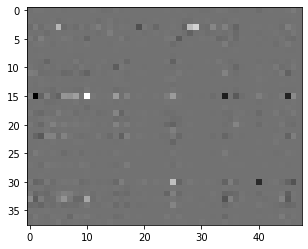

In [146]:
row,col=g.edge_index
M=torch.zeros(row.shape[0],g.x.shape[0])
for i,j in enumerate(row):
    M[i,j]=1
M=M.T

val=(M@R["edge_mlp.0"])[:,:48].detach().cpu().numpy()
row,col=val.shape

fig,ax=plt.subplots()
im=ax.imshow(val,cmap="Greys")
plt.show()

In [147]:
R["node_mlp_1.3"][1].shape

torch.Size([38, 48])

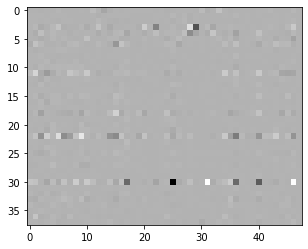

In [148]:
val=R["node_mlp_1.3"][1].detach().cpu().numpy()
row,col=val.shape

fig,ax=plt.subplots()
im=ax.imshow(val,cmap="Greys")
plt.show()